In [38]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############

import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')



In [39]:
no_mod_df = pd.read_csv('linked_dist_stats/no_mod.csv')
iqr_mod_df = pd.read_csv('linked_dist_stats/5IQR_all.csv')
no_mod_df.drop('Unnamed: 0',axis='columns',inplace=True)
no_mod_df.set_index('name', drop=True, inplace=True)

iqr_mod_df.drop('Unnamed: 0',axis='columns', inplace=True)
iqr_mod_df.set_index('name', drop=True, inplace=True)



In [62]:
#print(iqr_mod_df.head())
#print(no_mod_df.head())

In [42]:
#subtract IQR modified statistics from the unmodified statistics
delta_df = no_mod_df.subtract(iqr_mod_df)
delta_df.head(100)

,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
name,,,,,,,,,,,,,,,
0 to 20,112.012184,38.389482,10.0,5632.000000,1.057143,0.0,296.50,0.00,28.00,4.00,24.00,-32.000,64.000,0,0.0
20 to 50,459.224749,23.792910,5.0,2349.500000,0.161905,0.0,156.00,0.00,11.00,3.00,8.00,-9.000,23.000,0,0.0
50 to 80,245.527396,12.976598,4.0,1705.018519,0.052249,0.0,72.00,0.00,5.00,2.00,3.00,-2.500,9.500,0,0.0
80 to 110,245.879462,9.733434,2.0,1049.687500,0.022076,0.0,48.00,0.00,5.00,2.00,3.00,-2.500,9.500,0,0.0
110 to 140,98.736697,7.263671,2.0,637.636364,0.016125,0.0,35.36,0.00,3.00,1.00,2.00,-2.000,6.000,0,0.0
140 to 170,19.194034,6.852171,2.0,52.248039,0.013962,0.0,39.00,0.00,3.00,1.00,2.00,-2.000,6.000,0,0.0
170 to 200,24.347911,9.464930,4.0,59.375242,0.019101,0.0,42.00,0.00,5.00,2.00,3.00,-2.500,9.500,0,0.0
200 to 230,72.912100,14.116160,5.0,309.562958,0.029428,0.0,114.00,0.00,10.00,2.00,8.00,-10.000,22.000,0,0.0
230 to 260,48.119735,19.168885,6.0,78.490135,0.028892,0.0,140.00,1.00,12.00,3.00,9.00,-10.500,25.500,0,0.0


25 25


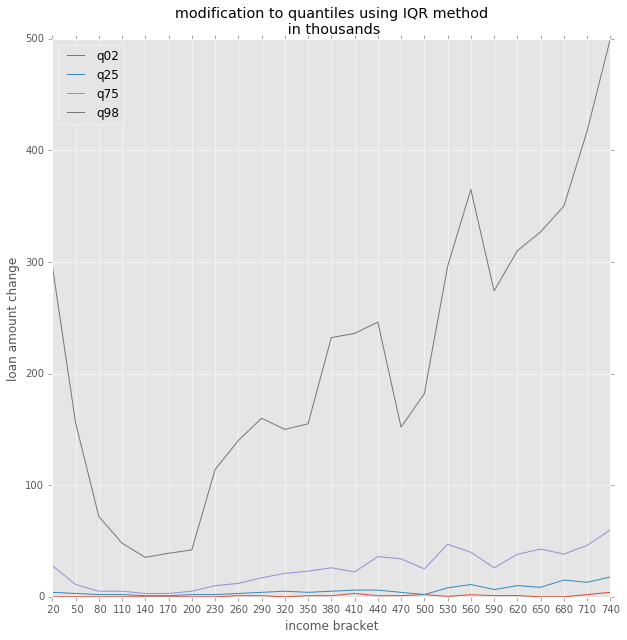

In [67]:
#plot deltas for each quantile (no mod minus IQR mod)
y = delta_df.q02
y1 = delta_df.q25
y2 = delta_df.q75
y3 = delta_df.q98
x = range(len(y))
my_xticks = [x[-3:] for x in delta_df.index]
print(len(x), len(y))
delta_viz = plt.figure(figsize=(10,10))
plt.xticks(x, my_xticks)

plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')

plt.ylabel('loan amount change')
plt.xlabel('income bracket')
plt.legend(loc='upper left')
plt.title('modification to quantiles using IQR method\n in thousands')
plt.show(delta_viz)

In [43]:
iqr_mod_df.head()

,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
name,,,,,,,,,,,,,,,
0 to 20,88.044178,126.841427,110.0,368.000000,10.142857,0.052632,338.0,7.0,181.0,56.0,125.0,-131.5,368.5,41276,1.862170
20 to 50,114.643708,176.717882,164.0,25.500000,4.738095,0.020408,444.0,8.0,254.0,83.0,171.0,-173.5,510.5,110307,4.976509
50 to 80,144.725370,237.079728,228.0,13.500000,3.537037,0.012658,560.0,14.0,341.0,117.0,224.0,-219.0,677.0,149167,6.729680
80 to 110,172.695009,293.844421,284.0,10.312500,3.009174,0.009174,650.0,23.0,420.0,149.0,271.0,-257.5,826.5,179258,8.087238
110 to 140,195.934678,345.346581,333.0,8.727273,2.671875,0.007194,750.0,35.0,494.0,183.0,311.0,-283.5,960.5,199283,8.990667


In [44]:
no_mod_df.head()

,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
name,,,,,,,,,,,,,,,
0 to 20,200.056362,165.230909,120.0,6000.000000,11.200000,0.052632,634.50,7.0,209.0,60.0,149.0,-163.5,432.5,41276,1.862170
20 to 50,573.868457,200.510793,169.0,2375.000000,4.900000,0.020408,600.00,8.0,265.0,86.0,179.0,-182.5,533.5,110307,4.976509
50 to 80,390.252766,250.056326,232.0,1718.518519,3.589286,0.012658,632.00,14.0,346.0,119.0,227.0,-221.5,686.5,149167,6.729680
80 to 110,418.574471,303.577854,286.0,1060.000000,3.031250,0.009174,698.00,23.0,425.0,151.0,274.0,-260.0,836.0,179258,8.087238
110 to 140,294.671375,352.610253,335.0,646.363636,2.688000,0.007194,785.36,35.0,497.0,184.0,313.0,-285.5,966.5,199283,8.990667
